In [36]:
import cirq
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error

#define utility functions

def simulate(circuit: cirq.Circuit) -> dict:
    """This funcion simulate a cirq circuit (without measurement) and output results in the format of histogram.
    """
    simulator = cirq.Simulator()
    result = simulator.simulate(circuit)
    
    state_vector=result.final_state_vector
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive

def count_gates(circuit: cirq.Circuit):
    """Returns the number of 1-qubit gates, number of 2-qubit gates, number of 3-qubit gates...."""
    counter=Counter([len(op.qubits) for op in circuit.all_operations()])
    
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    for i in range(2,20):
        assert counter[i]==0
        
    return counter

def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(image1, image2)

In [37]:
#load the mock data (for testing only)
files=os.listdir("mock_data")
dataset=list()
for file in files:
    with open('mock_data/'+file, "r") as infile:
        loaded = json.load(infile)
        dataset.append(loaded)

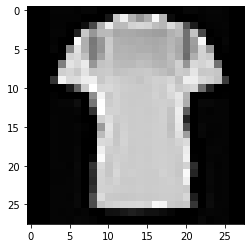

In [38]:
#load the actual hackthon data (fashion-mnist)
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')
#you can visualize it
import matplotlib.pyplot as plt
plt.imshow(images[1], cmap=plt.get_cmap('gray'))

In [40]:
import scipy
from qiskit.execute_function import execute
def scale(im, nR, nC):
    number_rows = len(im)     # source number of rows 
    number_columns = len(im[0])  # source number of columns 
    return [[ im[int(number_rows * r / nR)][int(number_columns * c / nC)]  
                 for c in range(nC)] for r in range(nR)]

num_image=len(images)
noramliz_const=np.max(num_image)
for i in range(num_image):
    images[i]=images[i]/noramliz_const

images_resized=[]
for i in range(num_image):
    images_resized.append(np.array(scale(images[i], 4, 4)).flatten())
input_data=np.array(images_resized)

In [41]:
outputdata=[]
for i in range(num_image):
    if labels[i] == True:
        outputdata.append(1)
    else:
        outputdata.append(0)

In [42]:
def Image_2_state(image):
    L,W=np.shape(image)
    num_q=int(np.ceil(np.log(L*W)/np.log(2)))
    cf=np.zeros((2**num_q),dtype=float)
    flattern_im=image.flatten()
    for i in range(L*W):
        cf[i]=flattern_im[i]
    norm_const=scipy.linalg.norm(cf)
    if norm_const==0:
        cf[0]=1
        return cf
    cf=cf/norm_const
    return cf
        

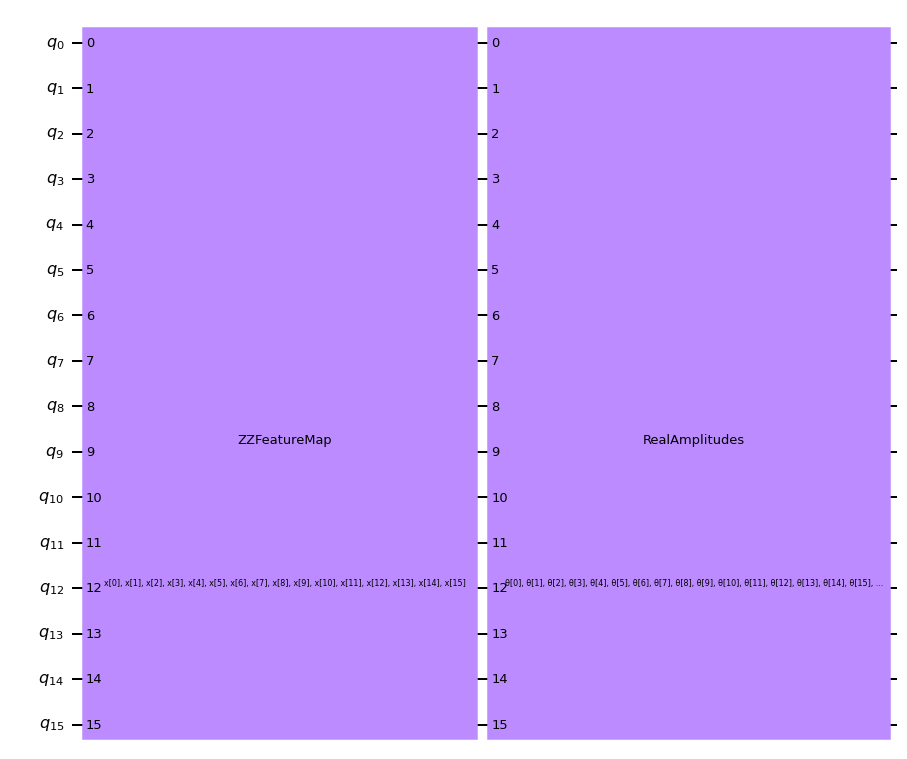

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

qc = QuantumCircuit(16)
feature_map = ZZFeatureMap(16)
ansatz = RealAmplitudes(16)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.draw(output="mpl")

In [44]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

In [45]:
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    
feature_map = ZZFeatureMap(16)
    
ansatz = QuantumCircuit(16, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(16, "с1"), list(range(16)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([i for i in range(8)], [i+8 for i in range(8)], "p1"), list(range(16)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(8, "c2"), list(range(8, 16)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p2"), list(range(8, 16)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(4, "c3"), list(range(12, 16)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p3"), list(range(12, 16)), inplace=True)

# fourth Convolutional Layer
ansatz.compose(conv_layer(1, "c4"), [15], inplace=True)

circuit = QuantumCircuit(16)
circuit.compose(feature_map, range(16), inplace=True)
circuit.compose(ansatz, range(16), inplace=True)

observable = SparsePauliOp.from_list([("Z"+"I"*15 , 1)])
from qiskit_machine_learning.neural_networks import EstimatorQNN

qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

In [46]:
import random
initial_point=[]
for i in range(np.size(ansatz.parameters)):
    initial_point.append((random.random()-0.5)*np.pi)

In [47]:
classifier = NeuralNetworkClassifier(
    qnn,
    loss = "cross_entropy",
    optimizer=COBYLA(maxiter=50),  # Set max iterations here
    initial_point=initial_point,
)

In [48]:
outputdata=np.asarray(outputdata[450:550])
input_data=np.asarray(input_data[450:550])

In [49]:
classifier.fit(input_data, outputdata)

In [52]:
len(classifier.weights)


126

In [54]:
def feature_map_cirs(image):
    X=np.array(scale(image, 4, 4)).flatten()
    reps=2
    qc=QuantumCircuit(16, name="Ansatz")
    for j in range(reps):
        for i in range(16):
            qc.h(i)
            qc.u1(X[i+j*120],i)
        for i in range(16):
            for k in range(16):
                ang=(np.pi - X[i+j*120])(np.pi -X[k+j*120])
                qc.u1(ang,i)
    return qc
                
def decode(histogram,shots=1024):
    images=np.zeros((4,4))
    for i in histogram.keys():
        ith=i//4
        jth=j%4
        images[ith,jth]+=histogram[i]/1024
    Normalized=np.max(images)
    return images/Normalized

In [65]:
qnn.weight_params

126

In [ ]:
classifier.score(input_data[45:55], outputdata[45:55])

0.5

In [ ]:
def simulate_qiskit(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram

In [ ]:
ansatz.parameters[0]

ParameterVectorElement(c2[0])

In [ ]:
params=classifier.weights

for i in range(len(params)):
    ansatz.bind_parameters({ansatz.parameters[i]: params[i]})



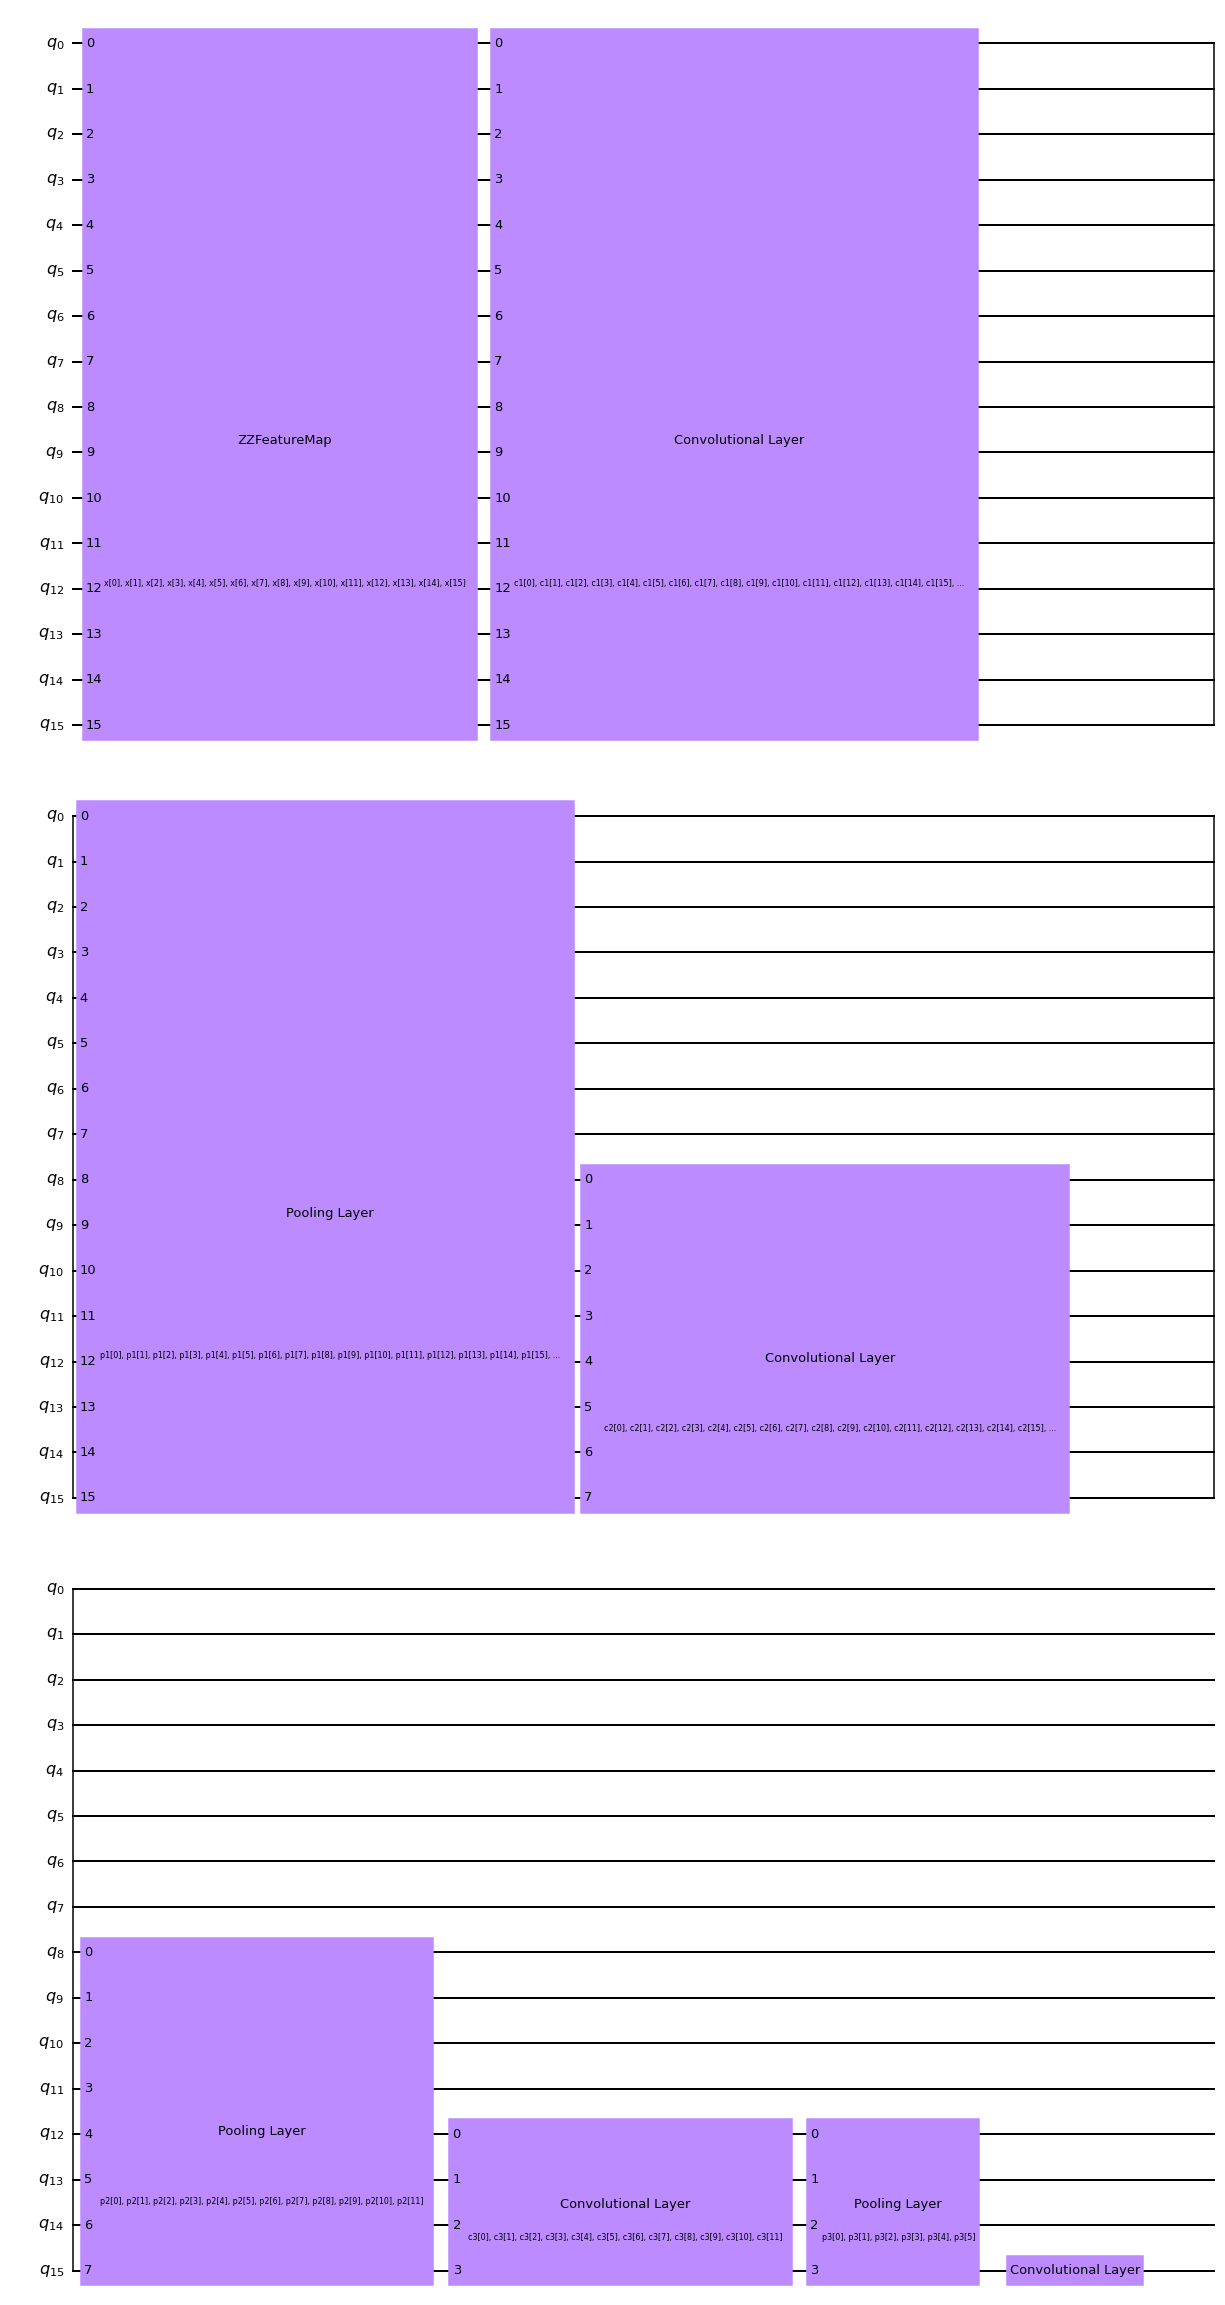

In [90]:
circuit = QuantumCircuit(16)
circuit.compose(feature_map, range(16), inplace=True)
circuit.compose(ansatz, range(16), inplace=True)

circuit.draw('mpl')

In [15]:
def count_gates_qiskit(circuit: qiskit.QuantumCircuit):
    """Returns the number of gate operations with each number of qubits."""
    return Counter([len(gate[1]) for gate in circuit.data])

In [22]:
def histogram_to_category_qiskit(histogram):
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive

In [16]:
#grade part1
from part1 import encode_cirq,decode

n=len(dataset)
mse=0
gatecount=0

for data in dataset:
    #encode image into circuit
    circuit=encode_qiskit(data['image'])
    #display()
    #simulate circuit
    histogram=simulate_qiskit(circuit)
    print(histogram)
    #count the number of 2-qubit gates
    gatecount+=count_gates_qiskit(circuit)[2]
    
    #reconstruct the image
    image_re=decode(histogram)
    
    #calculate mse
    mse+=image_mse(data['image'],image_re)
    
#fidelity of reconstruction
f=1-mse/n
gatecount=gatecount/n

#score for part1 
print(f*(0.999**gatecount))

[0, 1]
[0.5 0.5 0.5 0.5]
{0: 0.25, 1: 0.2500000000000001, 2: 0.2499999999999999, 3: 0.25}
[0, 1]
[1. 0. 0. 0.]
{0: 1.0}
0.999499874937461


In [24]:
classifier=qiskit.QuantumCircuit.from_qasm_file('part2.qasm')
    
score=0

for data in dataset:
    #encode image into circuit
    circuit=encode_qiskit(data['image'])
    
    nq1 = circuit.width()
    nq2 = classifier.width()
    nq = max(nq1, nq2)
    qc = qiskit.QuantumCircuit(nq)
    qc.append(circuit.to_instruction(), list(range(nq1)))
    qc.append(classifier.to_instruction(), list(range(nq2)))

    gatecount+=count_gates_qiskit(qc)[2]
    
    #simulate circuit
    histogram=simulate_qiskit(qc)
    
    #convert histogram to category
    cat=histogram_to_category_qiskit(histogram)
    
    
    if cat==data['category']:
        score+=1
#score
score=score/n
gatecount=gatecount/n

print(score*(0.999**gatecount))

[0, 1]
[0.5 0.5 0.5 0.5]
[0, 1]
[1. 0. 0. 0.]
0.0


In [18]:
#grade part 2

#load classifier circuit
with open('part2.pickle', 'rb') as f:
    classifier=pickle.load(f)
    
score=0


for data in dataset:
    #encode image into circuit
    circuit=encode_cirq(data['image'])
    
    #append with classifier circuit
    
    circuit.append(classifier)
    
    #simulate circuit
    histogram=simulate(circuit)
    
    #count the gate used in the circuit for score calculation
    gatecount+=count_gates(circuit)[2]
    
    #convert histogram to category
    cat=histogram_to_category(histogram)
        
    if cat==data['category']:
        score+=1
#score
score=score/n
gatecount=gatecount/n

print(score*(0.999**gatecount))

0.9997499061952749


In [19]:
classifier

0: ───Rx(π)───